# Describe the problem

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


# The Auto MPG dataset

## Get the data

First download and import the dataset using pandas:

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)                

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

The dataset contains a few unknown values:

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [6]:
dataset = dataset.dropna()

The **"Origin"** column is categorical, not numeric. So the next step is to one-hot encode the values in the column with `pd.get_dummies`.

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data

Review the joint distribution of a few pairs of columns from the training set.  

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

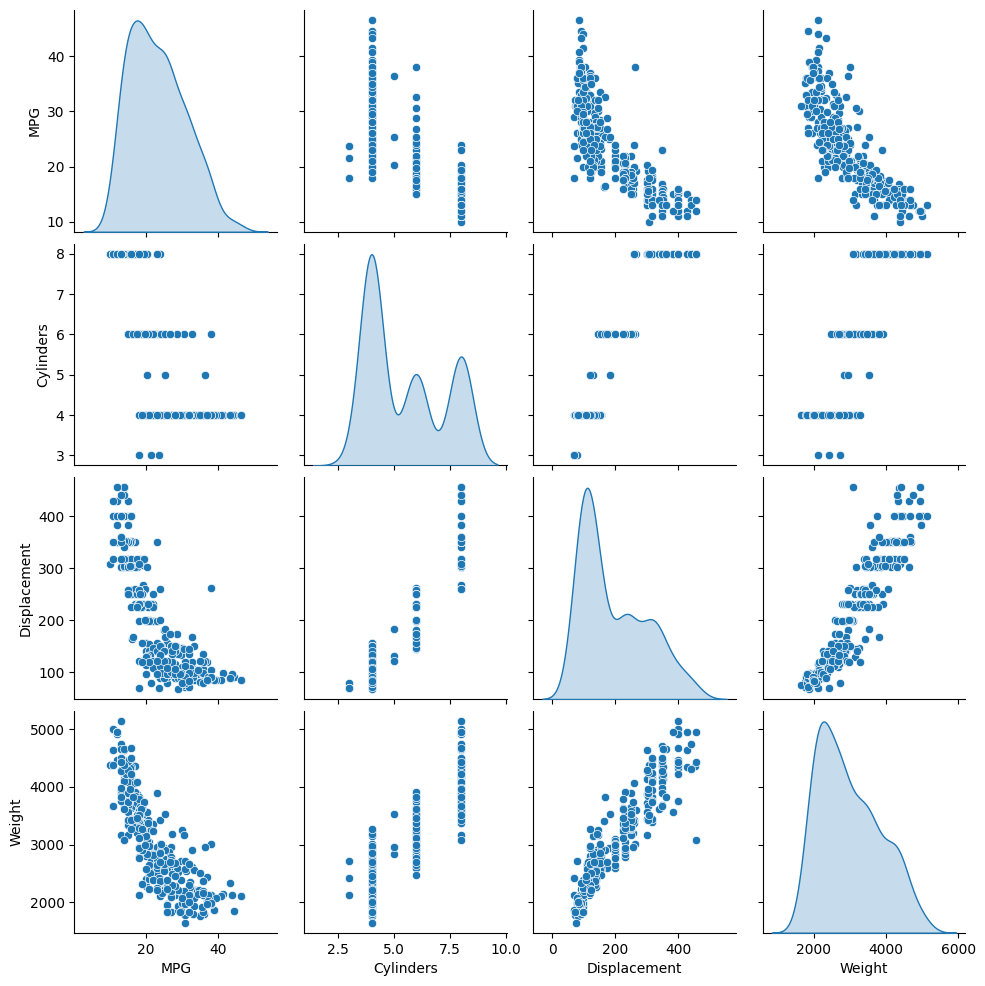

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value - the "label" - from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [14]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Normalization

In the table of statistics it's easy to see how different the ranger of each features are:

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason this is important is beacuse the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalizatio make training much more stable.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Nomalization.adapt`.

In [18]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [19]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

## Linear regeression with one variable

Begin with a single-varibale linear regression to predict 'MPG' from 'Horsepower'.


Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:
* Normalize the 'Horsepower' input features using the `tf.keras.layers.Normalization` preprocessing layer.
* Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy arrat made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [22]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [23]:
horsepower_model = keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that is has the expected shape of `(10, 1)`:

In [24]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 85ms/step


array([[ 1.183],
       [ 0.668],
       [-2.184],
       [ 1.659],
       [ 1.5  ],
       [ 0.589],
       [ 1.777],
       [ 1.5  ],
       [ 0.391],
       [ 0.668]], dtype=float32)

Once the model is built, configure the training precedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [26]:
horsepower_model.compile(loss="mae",
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

Use Kearas `Model.fit` to execute the training for 100 epochs:

In [28]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Supress logging
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2
)

CPU times: user 3.66 s, sys: 169 ms, total: 3.83 s
Wall time: 3.92 s


Visualize the model's training progress using the stats store in the `history` object:

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807015,4.198009,95
96,3.803543,4.178947,96
97,3.804021,4.181667,97
98,3.803319,4.189050,98
99,3.802515,4.197149,99


In [30]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True);

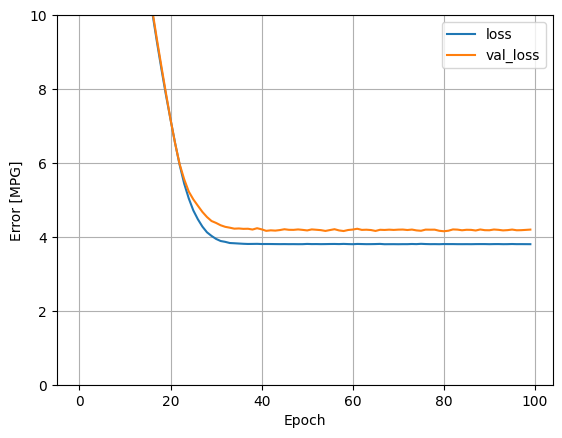

In [31]:
plot_loss(history)

Collect the results on the test for later:

In [32]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regress, it's easy to view the model's predictions as a function of the iniput:

In [33]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [36]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend();

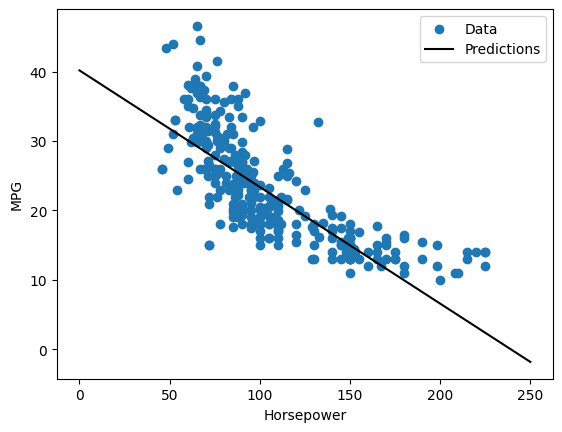

In [37]:
plot_horsepower(x, y)

# Linear refression with multiple inputs

You can use an almost identical setup to make predctions based on multiple inputs. This model still does the same $y = mx + b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with first layer being `normalizer (tf.keras.layers.Normalization(axis=-1))` you defined earlier and adapted to the whole dataset:

In [38]:
linear_model = tf.keras.Sequential([
    normalizer, 
    layers.Dense(units=1)
])

When you call `Model.predct` on a batch of inputs, it produces `units=1` outputs for each example:

In [39]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 73ms/step


array([[-1.338],
       [-0.314],
       [-1.04 ],
       [-1.363],
       [ 1.296],
       [-0.325],
       [ 1.424],
       [ 4.231],
       [-0.586],
       [ 1.628]], dtype=float32)

When you call the model, its weight matrices will be built - check that the `kernel` weight (the $m$ in $y = mx + b$) have a shape of `(9, 1)`:

In [40]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.371],
       [ 0.284],
       [-0.328],
       [ 0.501],
       [ 0.677],
       [-0.1  ],
       [ 0.611],
       [ 0.15 ],
       [-0.712]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [41]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mae")

In [42]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

CPU times: user 4.29 s, sys: 148 ms, total: 4.44 s
Wall time: 5.62 s


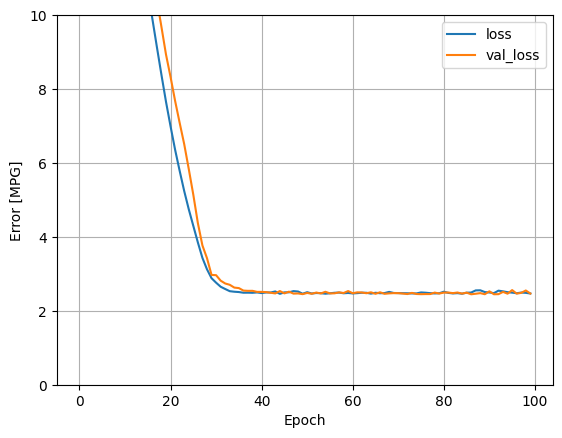

In [43]:
plot_loss(history)

In [44]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with horsepower_normalizer for single-input model and normalizer for a multiple-input model).
* Two hidden, non-linear, Dense layers with the ReLU activation dunction nonlinearity.
* A linear Dense single-output layer.

In [45]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm, 
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
  ])

  model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

## Regression using a DNN and a single input

Create a DNN model with only 'Horsepower' as inputs and horsepower_normalizer (defined earlier) as the normalization layer:

In [46]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a feq more trainable parameters than the linear models:

In [48]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Kearas `Model.fit`:

In [49]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    validation_split=.2,
    verbose=0
)

CPU times: user 4.57 s, sys: 173 ms, total: 4.75 s
Wall time: 6.9 s


This model does slightly better than the linear single-input `horsepower_model`:

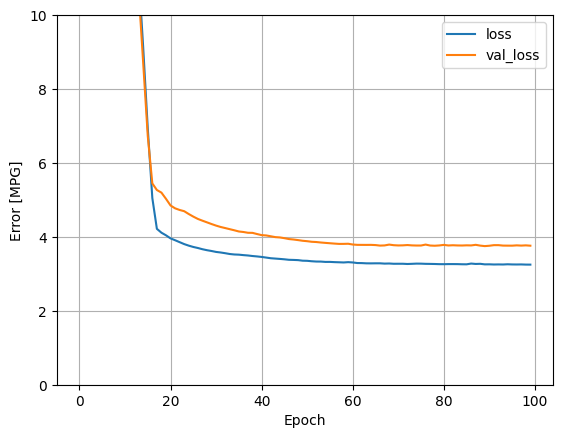

In [50]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [51]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


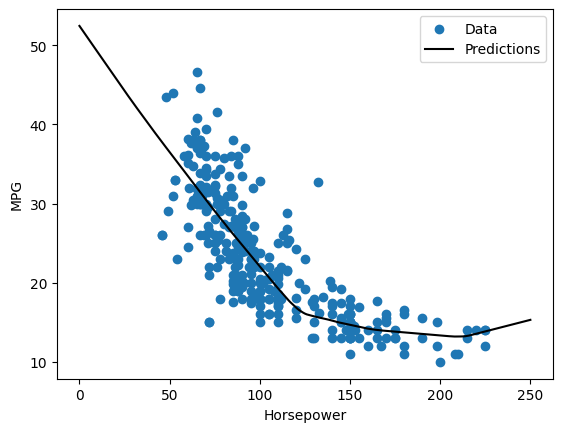

In [52]:
plot_horsepower(x, y)

In [53]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's preformance slightly improves on the validation dataset.

In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_split=.2,
    verbose=0
)

CPU times: user 5.04 s, sys: 164 ms, total: 5.21 s
Wall time: 7.37 s


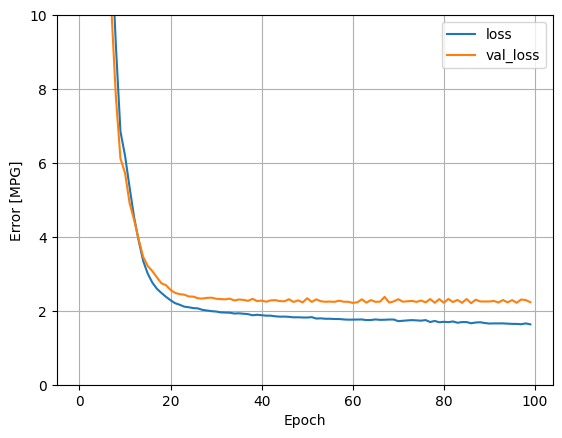

In [56]:
plot_loss(history)

In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.648998
linear_model,2.456225
dnn_horsepower_model,2.884167
dnn_model,1.713293


## Make predictions

3/3 [==============================] - 0s 2ms/step


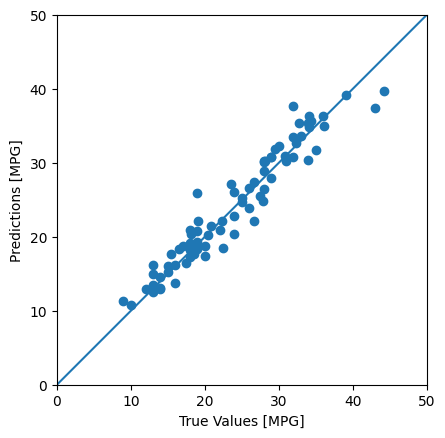

In [59]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)